In [127]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d

In [128]:
plt.rcParams['figure.figsize'] = [10,5]

# Coupled Waveguide

In [129]:
#Define conversion functions/factors to get to/from meep units and kms
#just need to specify c value
#meep to units
#Length factor to transform from meep units to kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


In [130]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803


In [131]:
#define cell size
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2)=(-8,8), y=(-sy/2,sy/2)=(-4,4)
sx = 90
sy = 7

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [132]:
#Geometry and sources definition
#each block has 3d widths, vector for center and material
#permettivities are expressed as relatives. otherwise can use refractive index

#waveguides widths and centers positions
wvg_1_width = 1
wvg_2_width = wvg_1_width

d = 1.1 #waveguides distance

wvg_1_y = d/2+wvg_1_width/2
wvg_2_y = wvg_1_y - wvg_1_width/2 - d - wvg_2_width/2

#waveguide material parameters
index_bgnd = 3.85
index_1 = 3.9
index_2 = index_1

#Source parameters
#Source frequency and time
f_source = 0.15 
t_source = 1 #exponential time to turn on source, to avoid steep jumps

#source position
x_source = -sx/2 + pml_thickness + 0.3
y_source = wvg_1_y

src_width = wvg_1_width

print("#Source frequency:", f_source*freq_unit*1e-12, "THz")
print("#Source vacuum wavelength:", c/(f_source*freq_unit)*1e+6, "um")
print("#Source background material wavelength:", (c/index_bgnd)/(f_source*freq_unit)*1e+6, "um")
print("#Source waveguide wavelength:", (c/index_1)/(f_source*freq_unit)*1e+6, "um")


#Source frequency: 44.9688687 THz
#Source vacuum wavelength: 6.666666666666667 um
#Source background material wavelength: 1.7316017316017314 um
#Source waveguide wavelength: 1.7094017094017095 um


In [133]:
#define geometry
geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,mp.inf),
                         center=mp.Vector3(0, 0),
                         material=mp.Medium(index=index_bgnd)),
    
            mp.Block(mp.Vector3(mp.inf,wvg_1_width,mp.inf),
                     center=mp.Vector3(0, wvg_1_y),
                     material=mp.Medium(index=index_1)),
            
            mp.Block(mp.Vector3(mp.inf,wvg_2_width,mp.inf),
                     center=mp.Vector3(0, wvg_2_y),
                     material=mp.Medium(index=index_2))
           ]

#define sources objects
sources = [mp.Source(mp.ContinuousSource(frequency=f_source, width=t_source),
                     component=mp.Ez,
                     center=mp.Vector3(x_source,y_source),
                     size=mp.Vector3(0,src_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]


#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

# Simulation Run

FloatProgress(value=0.0, description='0% done ', max=300.0)

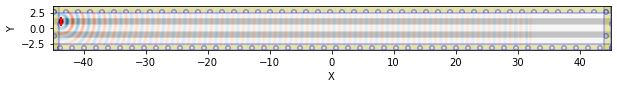

In [134]:
#Runs simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       normalize=True,
                       fields=mp.Ez,
                       realtime=False,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

run_time = 300

mp.verbosity(0)
sim.run(mp.at_every(1,animate), until=run_time)

animate.to_mp4(10, "Ez.mp4")

In [135]:
Video("Ez.mp4")

## Data Extraction

In [136]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
print(ez_data.shape)

ez_data_wvg_1 = sim.get_array(center=mp.Vector3(0,wvg_1_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
print(ez_data_wvg_1.shape)

ez_data_wvg_2 = sim.get_array(center=mp.Vector3(0,wvg_2_y), size=mp.Vector3(sx, 0.01), component=mp.Ez)
print(ez_data_wvg_2.shape)

x = np.arange(-sx/2, sx/2, 1/resolution)

(1800, 140)
(1800, 2)
(1800, 2)


# Envelope Calculation and Visualization

No handles with labels found to put in legend.


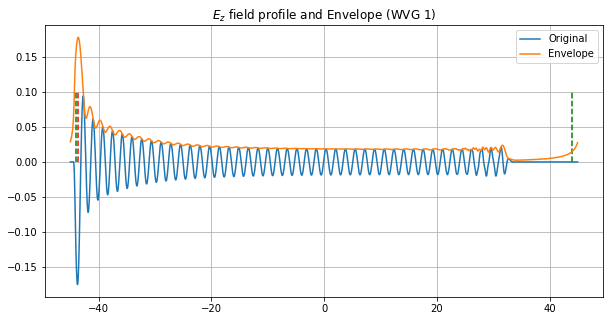

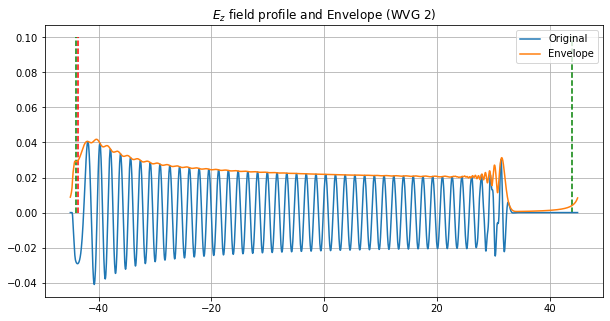

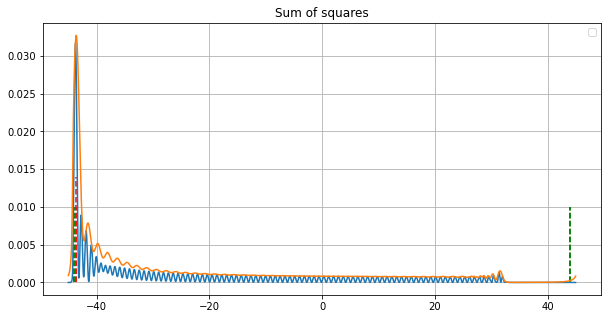

In [137]:

# Envelope calculation using hilbert transform
envelope_1 = np.abs(hilbert(ez_data_wvg_1[:,0]))
envelope_2 = np.abs(hilbert(ez_data_wvg_2[:,0]))
plt.figure()

plt.plot(x, ez_data_wvg_1[:,0], label="Original")
plt.plot(x, envelope_1, label="Envelope")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile and Envelope (WVG 1)")
plt.legend()
plt.grid()

plt.figure()
plt.plot(x, ez_data_wvg_2[:,0], label="Original")
plt.plot(x, envelope_2, label="Envelope")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")


plt.title(r"$E_z$ field profile and Envelope (WVG 2)")
plt.legend()
plt.grid()

plt.figure()
#sum of squares of components
plt.plot(x, ez_data_wvg_2[:,0]**2+ez_data_wvg_1[:,0]**2)

plt.vlines(x_source, 0, 0.01, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.01, color="green", linestyle="dashed")

#sum of squares of envelopes
plt.plot(x, envelope_1**2+envelope_2**2)

plt.vlines(x_source, 0, 0.014, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.01, color="green", linestyle="dashed")

plt.title(r"Sum of squares")
plt.legend()
plt.grid()

# Coupling Length Calculation

In [126]:
threshold = 0.15

max_val = np.amax(envelope_1)
max_index = np.argmax(envelope_1)

#logical mask application
values_mask = (envelope_1<threshold*max_val) & (x>x_source) & (x<x_bound_up)
   

try: 
        l_coupling = (x[values_mask])[0]-x_source
        print("#coupling length:", l_coupling, "Meep Units")
        print("#coupling length:", l_coupling*l_unit*1e+6, "um")
except:
        print("#Problem while calculating the coupling length")
    


#coupling length: 10.799999999999315 Meep Units
#coupling length: 10.799999999999313 um


In [9]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
print(eps_data.shape)

(1000, 140)


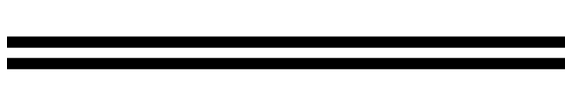

In [10]:
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary', origin="lower")
plt.axis('off')
plt.show()

In [11]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
print(ez_data.shape)

(1000, 140)


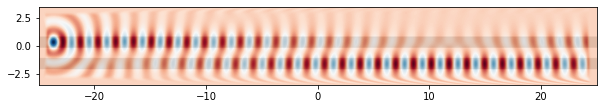

In [12]:
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary', origin="lower", extent=[-sx/2,sx/2,-sy/2,sy/2])
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9, origin="lower", extent=[-sx/2,sx/2,-sy/2,sy/2])
plt.show()

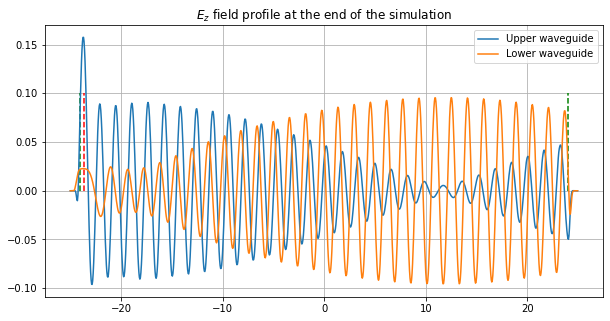

In [16]:
plt.figure()

plt.plot(x, ez_data_wvg_1[:,0], label="Upper waveguide")
plt.plot(x, ez_data_wvg_2[:,0], label="Lower waveguide")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile at the end of the simulation")
plt.legend()
plt.grid()

# Energy density profiles

In [17]:
energy_data_wvg_1 = sim.get_array(center=mp.Vector3(0,wvg_1_y), size=mp.Vector3(sx, 0.01), component=mp.EnergyDensity)
energy_data_wvg_2 = sim.get_array(center=mp.Vector3(0,wvg_2_y), size=mp.Vector3(sx, 0.01), component=mp.EnergyDensity)

print(energy_data_wvg_1.shape)
print(energy_data_wvg_2.shape)

(1000, 2)
(1000, 2)


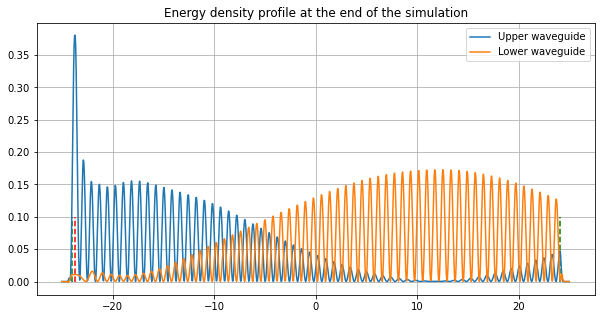

In [18]:
x = np.arange(-sx/2, sx/2, space_res)

plt.figure()

plt.plot(x, energy_data_wvg_1[:,0], label="Upper waveguide")
plt.plot(x, energy_data_wvg_2[:,0], label="Lower waveguide")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"Energy density profile at the end of the simulation")
plt.legend()
plt.grid()

# Energy density map

# Envelope calculation using cubic splines

In [24]:
indexes_1 = (find_peaks(ez_data_wvg_1[:,0]))[0]
print(indexes_1)

[  3   9  25  58  89 121 153 185 217 249 281 312 344 376 408 440 472 504
 536 568 600 632 664 697 734 772 805 837 869 901 933 965 990]


In [25]:
#interpolation
model1 = interp1d(x[indexes_1], ez_data_wvg_1[indexes_1,0], kind = 'cubic',bounds_error = False, fill_value=0.0)
x_min_int_1 = x[indexes_1[0]]
x_max_int_1 = x[indexes_1[-1]]

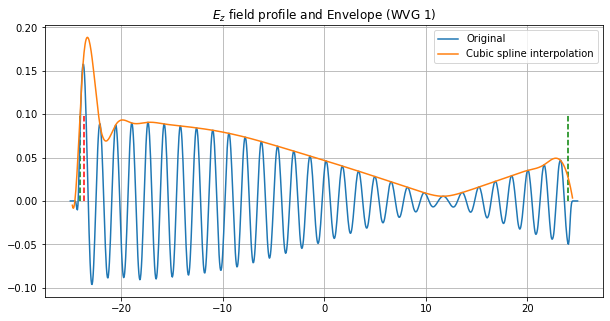

In [26]:
plt.figure()

plt.plot(x, ez_data_wvg_1[:,0], label="Original")

x_int_1 = x[(x>x_min_int_1) & (x<x_max_int_1)]
plt.plot(x_int_1, model1(x_int_1), label="Cubic spline interpolation")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1 , color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile and Envelope (WVG 1)")
plt.legend()
plt.grid()

In [27]:
indexes_2 = (find_peaks(ez_data_wvg_2[:,0]))[0]
print(indexes_2)

[  3  26  79 113 145 176 208 240 272 304 336 368 400 432 463 495 527 559
 591 623 655 687 719 750 782 814 846 878 910 942 974]


In [28]:
#interpolation
model2 = interp1d(x[indexes_2], ez_data_wvg_2[indexes_2, 0], kind = 'cubic',bounds_error = False, fill_value=0.0)
x_min_int_2 = x[indexes_2[0]]
x_max_int_2 = x[indexes_2[-1]]

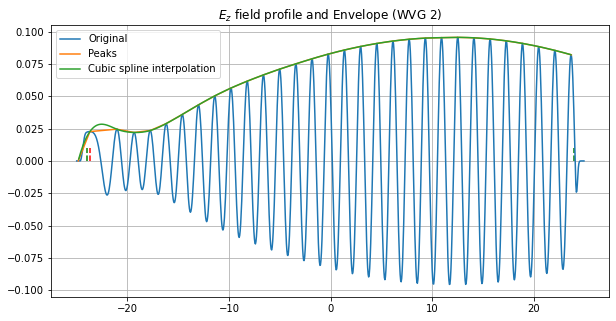

In [29]:
plt.figure()

plt.plot(x, ez_data_wvg_2[:,0], label="Original")
plt.plot(x[indexes_2], ez_data_wvg_2[indexes_2,0], label="Peaks")

x_int_2 = x[(x>x_min_int_2) & (x<x_max_int_2)]
plt.plot(x_int_2, model2(x_int_2), label="Cubic spline interpolation")

plt.vlines(x_source, 0, 0.01, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.01, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile and Envelope (WVG 2)")
plt.legend()
plt.grid()

# Comparison

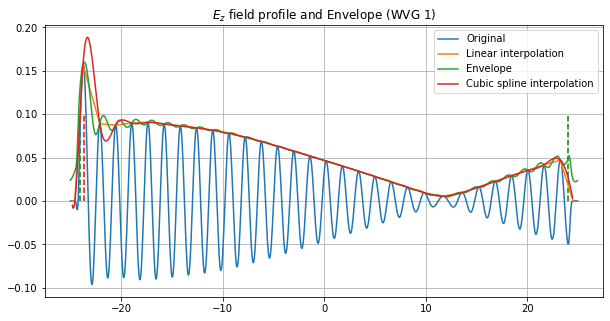

In [30]:
plt.figure()

plt.plot(x, ez_data_wvg_1[:,0], label="Original")
plt.plot(x[indexes_1], ez_data_wvg_1[indexes_1,0], label="Linear interpolation")

plt.plot(x, envelope_1, label="Envelope")

x_int_1 = x[(x>x_min_int_1) & (x<x_max_int_1)]
plt.plot(x_int_1, model1(x_int_1), label="Cubic spline interpolation")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile and Envelope (WVG 1)")
plt.legend()
plt.grid()

# Final profiles

## Cubic spline 

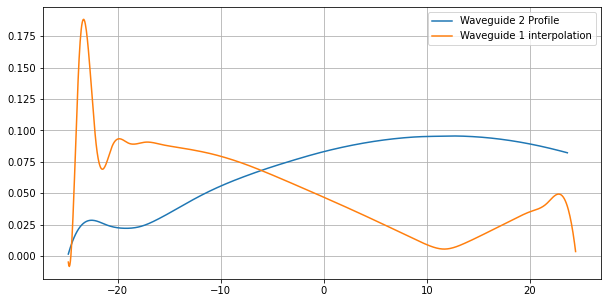

In [31]:
plt.figure()

plt.plot(x_int_2, model2(x_int_2), label="Waveguide 2 Profile")
plt.plot(x_int_1, model1(x_int_1), label="Waveguide 1 interpolation")

plt.legend()

plt.grid()



## Envelope

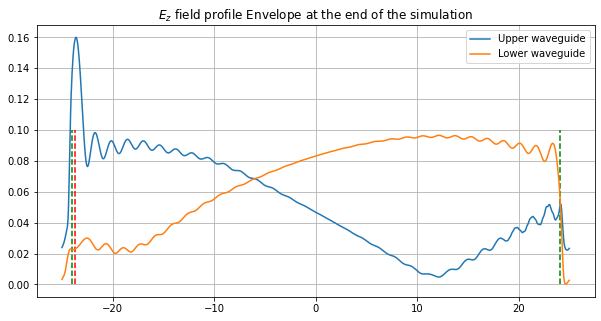

In [32]:
plt.figure()

plt.plot(x, envelope_1, label="Upper waveguide")
plt.plot(x, envelope_2, label="Lower waveguide")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile Envelope at the end of the simulation")
plt.legend()
plt.grid()

# Find the Coupling length

In [33]:
max_val = np.amax(envelope_1)
max_index = np.argmax(envelope_1)

In [34]:
#logical mask to get only values with e field under 10% of original value
values_mask = (envelope_1<0.1*max_val) & (x>x_source) & (x<x_bound_up)

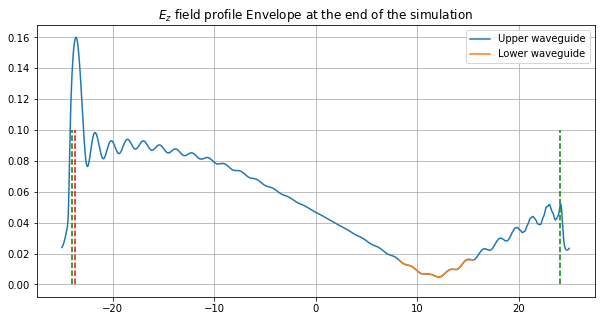

In [35]:
plt.figure()

plt.plot(x, envelope_1, label="Upper waveguide")
plt.plot(x[values_mask], envelope_1[values_mask], label="Lower waveguide")

plt.vlines(x_source, 0, 0.1, color="red", linestyle="dashed")
plt.vlines([-sx/2 + pml_thickness, sx/2 - pml_thickness], 0, 0.1, color="green", linestyle="dashed")

plt.title(r"$E_z$ field profile Envelope at the end of the simulation")
plt.legend()
plt.grid()

In [36]:
l_coupling = (x[values_mask])[0]-x_source
print("coupling length:", l_coupling, "Meep Units")
print("coupling length:", l_coupling*l_unit*1e+6, "um")

coupling length: 31.90000000000047 Meep Units
coupling length: 31.90000000000047 um
